In [ ]:
# I have either given, sought, nor received aid during this examination

# Q1 a

In [105]:
import json 
import random
import sys
import numpy as np
import matplotlib.pyplot as plt

In [92]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [93]:
def load(filename): # loads the weights and biases from a previosuly saved network
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

In [94]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def tanh(z):
    return (1+np.tanh(z/2))/2

def tanh_prime(z):
    return (1/(np.cosh(z/2)**2))/4

In [95]:
class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * tanh_prime(z)

In [96]:
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)

In [97]:
class Network(object):

    def __init__(self, sizes, cost=QuadraticCost): # need to tell the network what cost function to use
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer() # intialsises the weights
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = tanh(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, # eta is the learning rate
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            early_stopping_n = 0):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """

        # early stopping functionality:
        best_accuracy=1

        training_data = list(training_data)
        n = len(training_data)

        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)

        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))

            print("Epoch %s training complete" % j)

            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))

            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    #print("Early-stopping: Best so far {}".format(best_accuracy))
                else:
                    no_accuracy_change += 1

                if (no_accuracy_change == early_stopping_n):
                    #print("Early-stopping: No accuracy change in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.

        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = tanh(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = tanh_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights) # '**' - to the power of.
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

# Q1 b

In [8]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [9]:
net = Network([784, 40, 20, 10], cost=QuadraticCost)
net.default_weight_initializer()
net.SGD(training_data, 8, 20, 1.8, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9239 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9445 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9540 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9569 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9621 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9598 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9643 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9659 / 10000


([], [9239, 9445, 9540, 9569, 9621, 9598, 9643, 9659], [], [])

In [9]:
net = Network([784, 60, 10], cost=CrossEntropyCost)
net.default_weight_initializer()
net.SGD(training_data, 6, 100, 0.3, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9048 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9204 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9285 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9340 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9382 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9445 / 10000


([], [9048, 9204, 9285, 9340, 9382, 9445], [], [])

In [9]:
net = Network([784, 30, 25, 20, 10], cost=CrossEntropyCost)
net.default_weight_initializer()
net.SGD(training_data, 7, 10, 0.3, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9200 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9398 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9474 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9535 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9467 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9467 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9538 / 10000


([], [9200, 9398, 9474, 9535, 9467, 9467, 9538], [], [])

# Q1c

In [101]:
xi = np.array([0,1,2,3,4,5,6,7])
xii = np.array([0,1,2,3,4,5])
xiii = np.array([0,1,2,3,4,5,6])

In [103]:
yi = np.array([9239, 9445, 9540, 9569, 9621, 9598, 9643, 9659])
yii = np.array([9048, 9204, 9285, 9340, 9382, 9445])
yiii = np.array([9200, 9398, 9474, 9535, 9467, 9467, 9538])

In [107]:
import matplotlib.pyplot as plt

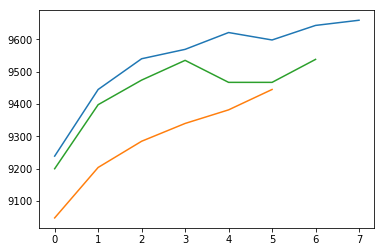

In [111]:
plt.plot(xi,yi)
plt.plot(xii,yii)
plt.plot(xiii,yiii) # greeen and corresponds to 1ii

Green one (1iii) decreases in accuracy after the 3rd epoch and never gets to higher accuarcy again so its been overtrained.

# Q1d

i) most often = 0
ii) least often = 9

# Q3a

In [113]:
data = np.genfromtxt(r"C:\Users\seane\Downloads\regression.csv", delimiter=",")

In [114]:
datamatrix = np.array([data])
# just putting the data into a matrix

In [115]:
A =datamatrix

In [116]:
np.shape(A)

(1, 1001, 2)

In [117]:
A =A[0,:]

In [118]:
np.shape(A)

(1001, 2)

In [119]:
A

array([[ 0.00000000e+00,  6.66254416e+00],
       [ 5.00000000e-03,  7.12572823e+00],
       [ 1.00000000e-02,  7.68314910e+00],
       ...,
       [ 4.99000000e+00, -1.91212156e+01],
       [ 4.99500000e+00, -1.75719493e+01],
       [ 5.00000000e+00, -1.81594668e+01]])

In [120]:
b = A[:,1]

In [121]:
b

array([  6.66254416,   7.12572823,   7.6831491 , ..., -19.12121562,
       -17.57194928, -18.15946684])

In [122]:
np.shape(b)

(1001,)

In [123]:
x0 = np.ones(1001)

In [124]:
Ai = A[:,0]
Ai

array([0.   , 0.005, 0.01 , ..., 4.99 , 4.995, 5.   ])

In [125]:
np.shape(Ai)

(1001,)

In [126]:
Anew = np.column_stack((x0,Ai)) # as in assignment 3, building the matrix A with first column as 1's

In [127]:
Anew

array([[1.   , 0.   ],
       [1.   , 0.005],
       [1.   , 0.01 ],
       ...,
       [1.   , 4.99 ],
       [1.   , 4.995],
       [1.   , 5.   ]])

In [128]:
np.shape(Anew)

(1001, 2)

In [129]:
Q,R = np.linalg.qr(A)

In [130]:
xhat = np.linalg.inv(R)@np.transpose(Q)@b

In [131]:
xhat

array([-2.22044605e-16,  1.00000000e+00])

In [132]:
def f(x):
    y = -2.22044605e-16 + 1.00000000e+00*x
    return y

# Q3b

In [75]:
f(Ai)

array([-2.22044605e-16,  5.00000000e-03,  1.00000000e-02, ...,
        4.99000000e+00,  4.99500000e+00,  5.00000000e+00])

In [76]:
np.linalg.norm(f(Ai)-b)

373.63970018961993

In [80]:
for i in range (0,1000):
    f(i) = Ai[i]
    e[i] = np.linalg.norm(f(i)-b(i)) 

SyntaxError: can't assign to function call (<ipython-input-80-3d74dbe3bc2c>, line 2)

In [133]:
plt.plot(x[i],e[i])

NameError: name 'x' is not defined

# Q3c

In [84]:
def orthdistance(x,y):
    np.mod(1.00000000e+00*x + y -2.22044605e-16)/np.sqrt(((1.00000000e+00)**2)+1)
    return orthdistance

In [87]:
g(x) = np.min(x,y,orthdistance)

SyntaxError: can't assign to function call (<ipython-input-87-2d23f9283ff3>, line 1)

# Q3d

In [88]:
for i in range (0,1000):
    g(i) = Ai[i]
    e[i] = np.linalg.norm(g(i)-b(i)) 

SyntaxError: can't assign to function call (<ipython-input-88-23a3651dcb2e>, line 2)

In [134]:
plt.plot(x[i],e[i])

NameError: name 'x' is not defined

# Q3e

In [135]:
plt.plot(x[i],f(x[i]))
plt.plot(x[i],g(x[i]))

NameError: name 'x' is not defined